In [1]:
import pandas as pd
rna_data = pd.read_csv('human_protein_atlas_rna_tissue_consensus.tsv', sep='\t')

tissue = 'skeletal muscle'
tissue_rna_data = rna_data[rna_data['Tissue'] == tissue]
tissue_rna_data_ntpm = tissue_rna_data.groupby('Gene name')['nTPM'].mean() 
#tissue_rna_data.index = tissue_rna_data['Gene name']

median_rna_data_ntpm = rna_data.groupby('Gene name')['nTPM'].median() 

In [2]:
rna_data_no_duplicates = rna_data.groupby(['Gene name','Tissue'])['nTPM'].mean().reset_index()
rna_data_no_duplicates.head()

,Gene name,Tissue,nTPM
0,A1BG,adipose tissue,0.1
1,A1BG,adrenal gland,0.1
2,A1BG,amygdala,0.0
3,A1BG,appendix,0.1
4,A1BG,basal ganglia,0.0


# Analysis of metablic genes 

In [3]:
# load recon3d gene annotation json
import json
with open('recon3d_gene_annotation.json') as f:
    recon3d_gene_annotation = json.load(f)['results']

metabolic_genes_human_protein_atlas = [entry['name'] for entry in recon3d_gene_annotation if entry['name'] in rna_data_no_duplicates['Gene name'].values]

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

expression_ntpm =  rna_data_no_duplicates.pivot(index='Gene name', columns='Tissue', values='nTPM')
# Set missing values to 0
expression_ntpm = expression_ntpm.fillna(0)


# Filter metabolic genes
expression_ntpm = expression_ntpm.loc[metabolic_genes_human_protein_atlas]

# Normalize data by gene average accross tissues
expression_ntpm = expression_ntpm.div(expression_ntpm.mean(axis=1), axis=0)

# Binarize data by 50% of mean expression
expression_ntpm = expression_ntpm.applymap(lambda x: 1 if x > 1 else 0)

# Drop duplicates
expression_ntpm = expression_ntpm.drop_duplicates()

# Union of all muscles 
expression_ntpm['muscle'] = expression_ntpm[['skeletal muscle', 'heart muscle', 'smooth muscle']].max(axis=1)

# Write to csv
expression_ntpm['muscle'].to_csv('muscle_expression.csv', header=True)

/home/daniel/miniconda3/envs/skimpy-env/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


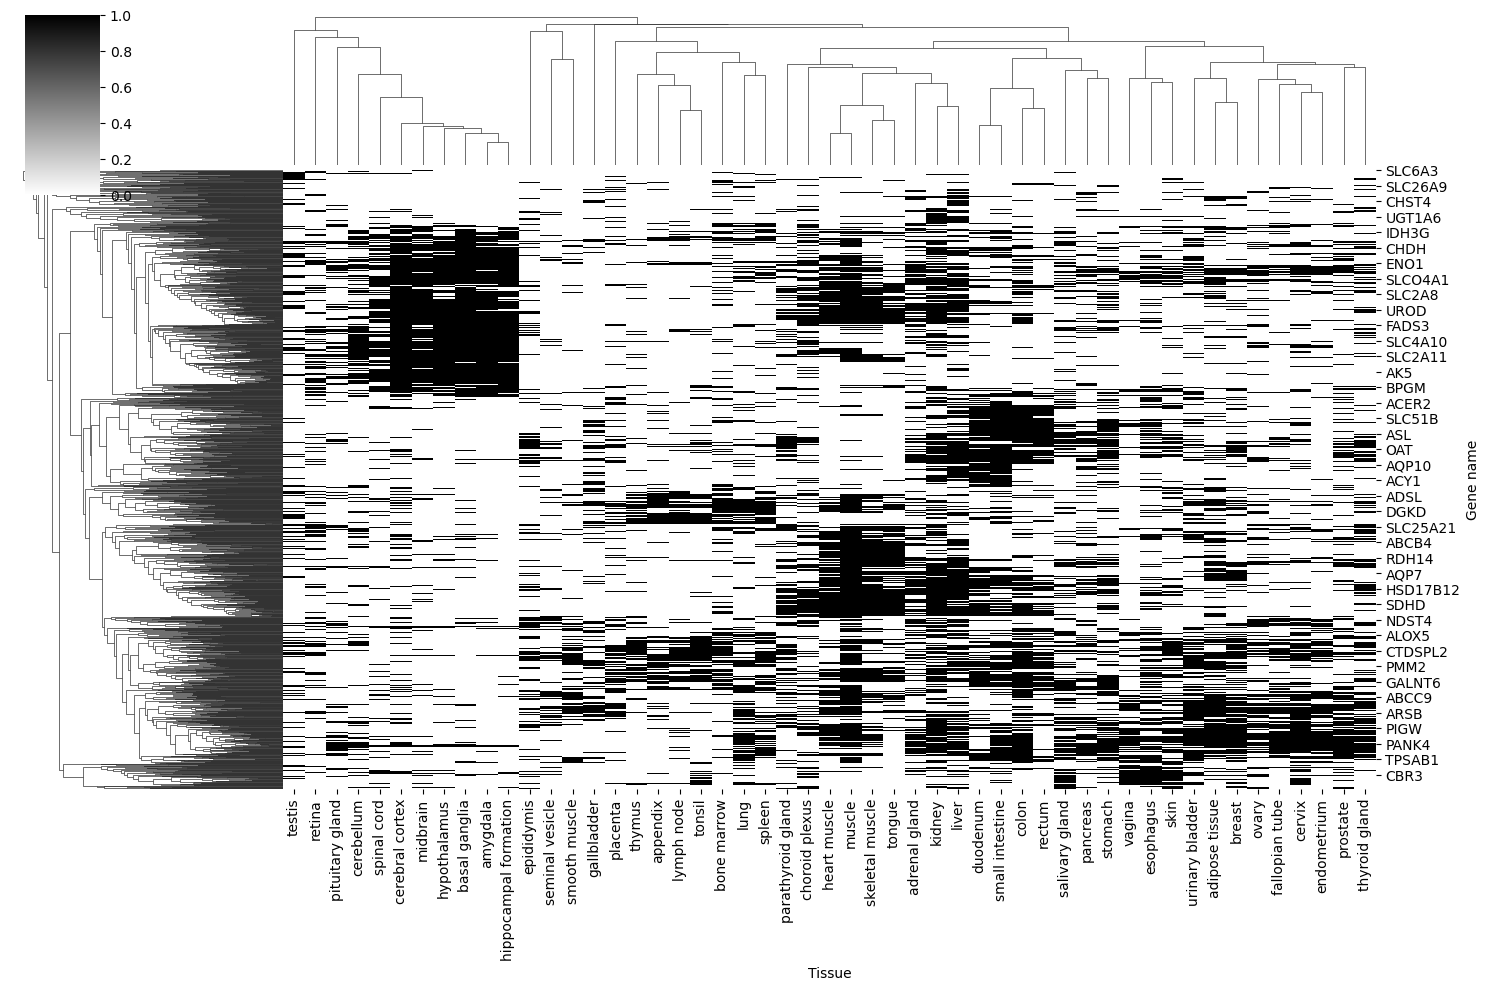

In [5]:
sns.clustermap(expression_ntpm, cmap='binary', figsize=(15, 10), metric='cosine', method='average')

# Analysis of receptor rexpressions

In [6]:
ensamble2reactome = pd.read_table('Ensembl2Reactome.txt', header=None, delimiter="\t", names=['Ensemble', 'Reactome','URL', 'Pathway','Something','Species'])
filter_human = ensamble2reactome['Species'] == 'Homo sapiens'

ensamble2reactome = ensamble2reactome[filter_human]

In [7]:
# list all pathways that contain certain keywords 
keywords = ['receptors', 'hormone', 'signaling']

# Function to check if keyword is in pathway description
def has_any_keyword(p,kwds):
    for k in kwds:
        if k in p.lower():
            return True

signaling_pathways = [ p for p in ensamble2reactome.Pathway.unique() if has_any_keyword(p,keywords)]

In [8]:
# Filter out genes that contain a signalign pathway
signaling_genes =  ensamble2reactome[ensamble2reactome.Pathway.isin(signaling_pathways)].Ensemble

In [28]:
rna_data_no_duplicates = rna_data.groupby(['Gene','Tissue'])['nTPM'].mean().reset_index()

# FIlter 
#expression_ntpm =  rna_data_no_duplicates[rna_data_no_duplicates.Gene.isin(signaling_genes)].pivot(index='Gene', columns='Tissue', values='nTPM')
# No Filter
expression_ntpm =  rna_data_no_duplicates.pivot(index='Gene', columns='Tissue', values='nTPM')

# Set missing values to 0
expression_ntpm = expression_ntpm.fillna(0)

# Normalize data by gene average accross tissues
expression_ntpm = expression_ntpm.div(expression_ntpm.mean(axis=1), axis=0)

# Binarize data by 50% of mean expression
expression_ntpm = expression_ntpm.applymap(lambda x: 1 if x > 1 else 0)

# Drop duplicates
expression_ntpm = expression_ntpm.drop_duplicates()

# Union of all muscles 
expression_ntpm['muscle'] = expression_ntpm[['skeletal muscle', 'heart muscle', 'smooth muscle']].max(axis=1)


In [29]:
# Drop zero rows 
expression_ntpm = expression_ntpm.loc[~(expression_ntpm==0).all(axis=1)]

In [30]:
# Annotate gene name from Gene name column of rna_data
tissues = expression_ntpm.columns
gene_gene_name_map = rna_data[['Gene','Gene name']].drop_duplicates()
expression_ntpm = expression_ntpm.join(gene_gene_name_map.set_index('Gene'))



/home/daniel/miniconda3/envs/skimpy-env/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


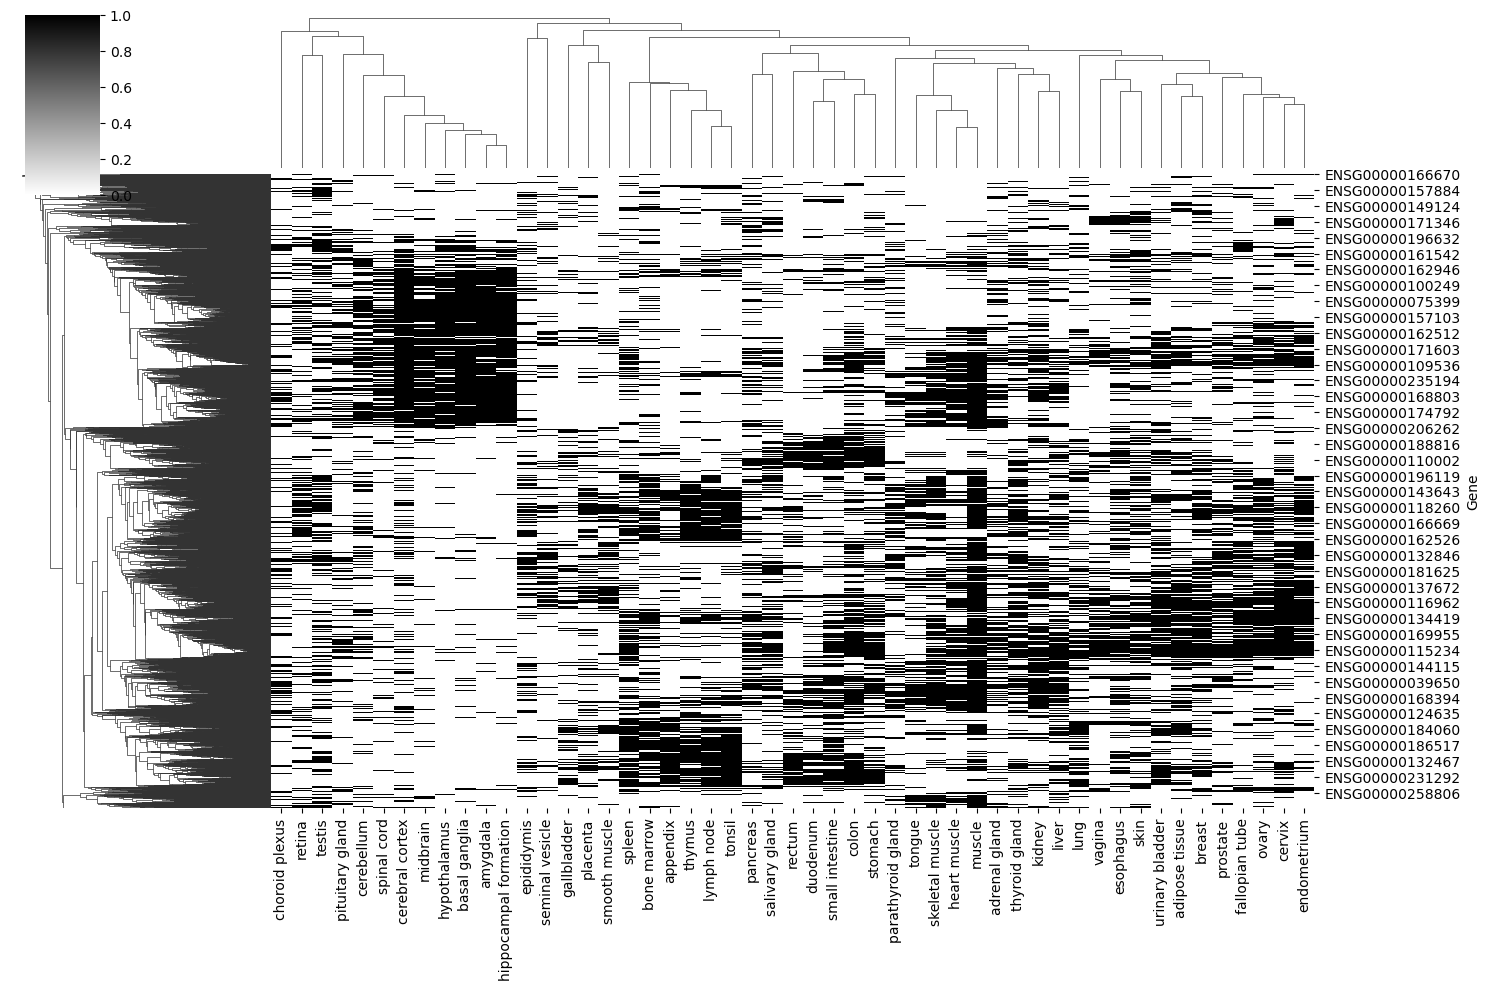

In [31]:
sns.clustermap(expression_ntpm[tissues], cmap='binary', figsize=(15, 10), metric='cosine', method='average')

In [32]:
# Pathway enrichment analysis
from gprofiler import GProfiler

gp = GProfiler('DRW')

muscle_genes = expression_ntpm['Gene name'][ expression_ntpm['skeletal muscle'] == 1].values

gp_results = gp.gprofile(organism='hsapiens', query=list(muscle_genes), src_filter=["GO:MP","KEGG","REAC","WP","CORUM","HP"])

In [33]:
pd.DataFrame(gp_results)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,True,4.730000e-91,666,3724,486,0.131,0.730,REAC:R-HSA-8953854,rea,1,Metabolism of RNA,1,"UPF1,POLR2J,GCFC2,ELAC2,TSR3,PSMB1,RPS20,UTP18..."
1,1,True,2.300000e-52,293,3724,232,0.062,0.792,REAC:R-HSA-72766,rea,1,Translation,1,"RPS20,LARS2,RPL26L1,MRPS10,MRPL43,MRPS35,MRPS2..."
2,1,True,1.730000e-41,1701,1318,794,0.602,0.467,HP:0011804,hp,1,Abnormality of muscle physiology,1,"DPM1,ALS2,KDM1A,ARX,HCCS,CREBBP,LAMP2,CRLF1,IF..."
3,1,True,1.660000e-38,203,3724,164,0.044,0.808,REAC:R-HSA-72312,rea,1,rRNA processing,1,"ELAC2,TSR3,RPS20,UTP18,TFB1M,RPL26L1,MTREX,NOP..."
4,1,True,6.900000e-38,174,3724,146,0.039,0.839,REAC:R-HSA-1428517,rea,1,The citric acid (TCA) cycle and respiratory el...,1,"NDUFAF7,NDUFAB1,PDK4,PDK2,UQCRC1,NDUFS1,MPC1,C..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,1,True,4.610000e-02,111,1318,59,0.045,0.532,HP:0003394,hp,1,Muscle cramps,1,"LAMP2,SCN4A,RRM2B,PYGM,VPS35,CHMP2B,GNAS,GNA11..."
545,1,True,4.770000e-02,33,1318,23,0.017,0.697,HP:0002181,hp,1,Cerebral edema,1,"NDUFS1,NDUFAF5,FOXRED1,TIMMDC1,ACADM,NDUFB3,ND..."
546,1,True,4.900000e-02,20,1318,16,0.012,0.800,HP:0003688,hp,1,Cytochrome C oxidase-negative muscle fibers,1,"COX10,RRM2B,TWNK,FASTKD2,COX6B1,SCO1,TACO1,POL..."
547,1,True,4.960000e-02,15,1712,14,0.008,0.933,CORUM:194,cor,1,PA28gamma-20S proteasome,1,"PSMB1,PSMA4,PSMA3,PSMB5,PSMA6,PSMA7,PSMA2,PSMB..."
